## Analyze A/B Test Results

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
import time
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [64]:
#Read in the dataset and take a look at the top few rows
df = pd.read_csv('ab_data.csv')

In [35]:
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [36]:
# find the number of rows in the dataset.
df.shape

(294478, 5)

c. The number of unique users in the dataset.

In [5]:
# The number of unique users in the dataset.
df['user_id'].nunique()

290584

d. The proportion of users converted.

In [6]:
# The proportion of users converted.
df.converted.mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [37]:
df.query("group == 'treatment' & landing_page != 'new_page'").shape[0] + df.query("group == 'control' & landing_page != 'old_page'").shape[0]

3893

f. Do any of the rows have missing values?

In [8]:
df.isnull().any()

user_id         False
timestamp       False
group           False
landing_page    False
converted       False
dtype: bool

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [65]:
# Remove the inaccurate rows
not_matched1 = df.query("group == 'treatment' & landing_page != 'new_page'").index
not_matched2 = df.query("group == 'control' & landing_page != 'old_page'").index
df2 = df
df2.drop(index = not_matched1, axis=0, inplace=True) 
df2.drop(index = not_matched2, axis=0, inplace=True) 

In [66]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [11]:
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [67]:
duplicate_id = df2[df2.duplicated('user_id')]
duplicate_id['user_id']

2893    773192
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [13]:
duplicate_id

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [68]:
# Remove one of the rows with a duplicate user_id.
df2 = df2.drop_duplicates(subset='user_id', keep = 'first')
# Check again if the row with a duplicate user_id is deleted or not
df2.user_id.duplicated().sum()

0

`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [42]:
# The probability of an individual converting regardless of the page they receive
p_pop = df2.converted.mean()
p_pop

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [43]:
p_control = df2[df2['group'] == 'control'].converted.mean()
p_control

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [44]:
p_treatment = df2[df2['group'] == 'treatment'].converted.mean()
p_treatment

0.11880806551510564

In [45]:
# Calculate the actual difference (obs_diff) between the conversion rates for the two groups.
obs_diff = p_treatment - p_control
obs_diff

-0.0015782389853555567

d. What is the probability that an individual received the new page?

In [46]:
p_new_page = df2.query('landing_page == "new_page"').shape[0] / df2.shape[0]
p_new_page

0.5000619442226688

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

**Your answer goes here.**
Based on the previous results, there's no evidence that treatment group leads to more conversions because the conversion rate for the control group is slightly larger than of the treatment group.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**Put your answer here.**
#### Null : P_new - P_old <= 0
#### Alt : P_new - P_old > 0

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [47]:
p_new = df2.converted.mean()
p_new

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [48]:
p_old = p_new
p_old

0.11959708724499628

c. What is $n_{new}$?

In [49]:
n_new = df2.query("group == 'treatment'").shape[0]
n_new

145310

d. What is $n_{old}$?

In [50]:
n_old = df2.query("group == 'control'").shape[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [51]:
# Simulate a Sample for the treatment Group
new_page_converted = np.random.choice([0, 1], size = n_new, p = [1 - p_new, p_new])

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [52]:
# Simulate a Sample for the control Group
old_page_converted = np.random.choice([0, 1], size = n_old, p = [1 - p_old, p_old])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [53]:
diff_converted = new_page_converted.mean() - old_page_converted.mean()
diff_converted

-0.0029548881371864316

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [54]:
start_time = time.time()
# Sampling distribution 
p_diffs = []
new_converted_simulation = np.random.binomial(n_new, p_new, 10000)/n_new 
old_converted_simulation = np.random.binomial(n_old, p_old, 10000)/n_old 
p_diffs = new_converted_simulation - old_converted_simulation
   
print("%s seconds" %(time.time() - start_time))

0.008000373840332031 seconds


i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

Text(0, 0.5, 'Frequency of Difference in Coverting Rate')

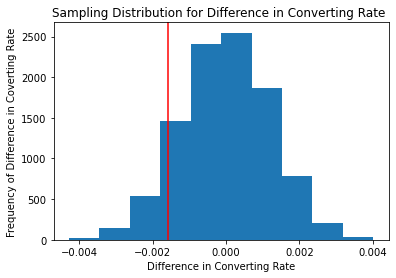

In [55]:
plt.hist(p_diffs);
plt.axvline(obs_diff, color = 'r')
plt.title("Sampling Distribution for Difference in Converting Rate ")
plt.xlabel('Difference in Converting Rate')
plt.ylabel('Frequency of Difference in Coverting Rate')

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [56]:
p_diffs = np.array(p_diffs)
p_value = (p_diffs > obs_diff).mean()
p_value

0.9013

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**Put your answer here.**
It's called p_value, and a p_value of .9039 with alpha of .05 we then fail to reject the null and there's no difference between the new and old pages.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [57]:
import statsmodels.api as sm

# number of conversions with the old_page
convert_old = sum((df2.group == 'control') & (df2.converted == 1))

# number of conversions with the new_page
convert_new = sum((df2.group == 'treatment') & (df2.converted == 1))

# number of individuals who were shown the old_page
n_old = n_old

# number of individuals who received new_page
n_new = n_new

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [58]:
# Compute Z-score and P-value
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], 0, 'larger')
print(z_score, p_value)

-1.3109241984234394 0.9050583127590245


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**Put your answer here.**
Z-score is smaller than Z-alpha (1.645) for one_tailed test, and P_value is larger than .05 so we fail to reject the null hypothesis as they agree with the previuos findings so far.  

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Put your answer here.**
Logistic Regression

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [69]:
#Create intercept column.
df2.loc[:, ('intercept')] = 1
#Create dummy variables
ab_page = pd.get_dummies(df2['group'])
ab_page.drop('control', axis=1)
df2['ab_page'] = ab_page['treatment']
df2.head()

C:\Users\Zeina\anaconda3\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\Zeina\AppData\Local\Temp/ipykernel_7236/1647894464.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['ab_page'] = ab_page['treatment']


,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [71]:
log_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = log_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [72]:
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212780.3502
Date:               2022-08-22 03:06 BIC:              212801.5095
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           1                LL-Null:          -1.0639e+05
Df Residuals:       290582           LLR p-value:      0.18988    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

In [73]:
np.exp(-0.0150)

0.9851119396030626

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

**Put your answer here.**
Although the coefficient value for treatment group indicates that conversion is .985 times as likely for treatment group than control group, but P_value is .1899 and it's larger than Type 1 error rate so it indicates a weak evidence and fail to reject the null hypothesis. It's different because the statistics' formula used for calculating P_value is different.
Null hypotheses in my regression model is that treatment group is no different than control group in convertion proportion and the alternative that treatment leads to more covertion rates than control group.

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Put your answer here.**
Adding other factors could make the regression has more accuracy and make a good interpretation, but it might as well to cause multicolinearity.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [74]:
# Load countries data
countries_df = pd.read_csv('./countries.csv')
# Join with the df2 dataframe
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')

In [75]:
### Create the necessary dummy variables
df_new[['US', 'UK', 'CA']] = pd.get_dummies(df_new['country'])
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,US,UK,CA
user_id,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0


h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [76]:
### Fit Linear Model And Obtain the Results
log_mod2 = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'UK', 'US']])
results = log_mod2.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212781.1253
Date:               2022-08-22 03:16 BIC:              212823.4439
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           3                LL-Null:          -1.0639e+05
Df Residuals:       290580           LLR p-value:      0.17599    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9893    0.0089  -223.7628  0.0000  -2.0067  -1.9718
ab_page      -0.0149    0.0114    -1.3069  0.1912  -0.0374   0.0075
UK            0.0099    0.0133     0.7433  0.4573  -0.0162   0.0359
US           -0.0408    0.0269    -1.5161  0.1295  -0.0934   0.0119
==================================================================

"""

In [77]:
np.exp(-0.0149), np.exp(0.0099), np.exp(-0.0408)

(0.9852104557227469, 1.0099491671175422, 0.9600211149716509)

### Final Conclusions:  P Values of the three coefficients are larger than Type 1 error (.05), so we fail to reject the null hypothesis, so treatment group doesn't have more conversions than control group and old page should be continued to be used, but as practically statistic it is not significant and further investigation should be done.

<a id='conclusions'></a>
## Conclusions

Congratulations on completing the project! 

### Gather Submission Materials

Once you are satisfied with the status of your Notebook, you should save it in a format that will make it easy for others to read. You can use the __File -> Download as -> HTML (.html)__ menu to save your notebook as an .html file. If you are working locally and get an error about "No module name", then open a terminal and try installing the missing module using `pip install <module_name>` (don't include the "<" or ">" or any words following a period in the module name).

You will submit both your original Notebook and an HTML or PDF copy of the Notebook for review. There is no need for you to include any data files with your submission. If you made reference to other websites, books, and other resources to help you in solving tasks in the project, make sure that you document them. It is recommended that you either add a "Resources" section in a Markdown cell at the end of the Notebook report, or you can include a `readme.txt` file documenting your sources.

### Submit the Project

When you're ready, click on the "Submit Project" button to go to the project submission page. You can submit your files as a .zip archive or you can link to a GitHub repository containing your project files. If you go with GitHub, note that your submission will be a snapshot of the linked repository at time of submission. It is recommended that you keep each project in a separate repository to avoid any potential confusion: if a reviewer gets multiple folders representing multiple projects, there might be confusion regarding what project is to be evaluated.

It can take us up to a week to grade the project, but in most cases it is much faster. You will get an email once your submission has been reviewed. If you are having any problems submitting your project or wish to check on the status of your submission, please email us at dataanalyst-project@udacity.com. In the meantime, you should feel free to continue on with your learning journey by beginning the next module in the program.